## Housing Price Prediction with Random Forest Case Study Yogyakarta

### 1. Load dataset

In [2]:
# import semua library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import joblib

%matplotlib inline

In [3]:
# load dataset yang sudah dibersihkan sebelumnya
dataset = pd.read_csv("data/rumahcom_clean.csv")
dataset.head()

,harga,lokasi,luas_bangunan,luas_tanah,kamar,kamar_mandi,listrik,interior,parkir,sertifikat
0,180000000,Sleman,21,60,1,1,900,Tak Berperabot,1,SHM - Sertifikat Hak Milik
1,180000000,Sleman,21,77,1,1,1300,Tak Berperabot,1,SHM - Sertifikat Hak Milik
2,180000000,Sleman,21,77,1,1,1300,Tak Berperabot,1,SHM - Sertifikat Hak Milik
3,180000000,Sleman,21,77,1,1,1300,Tak Berperabot,1,SHM - Sertifikat Hak Milik
4,180000000,Sleman,21,77,2,1,1300,Tak Berperabot,1,SHM - Sertifikat Hak Milik


### 2. Data understanding

In [4]:
# Melihat tipe data yang ada di setiap field
dataset.dtypes

harga             int64
lokasi           object
luas_bangunan     int64
luas_tanah        int64
kamar             int64
kamar_mandi       int64
listrik           int64
interior         object
parkir            int64
sertifikat       object
dtype: object

In [5]:
# mengecek jumlah data yang tidak kosong
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3272 entries, 0 to 3271
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   harga          3272 non-null   int64 
 1   lokasi         3272 non-null   object
 2   luas_bangunan  3272 non-null   int64 
 3   luas_tanah     3272 non-null   int64 
 4   kamar          3272 non-null   int64 
 5   kamar_mandi    3272 non-null   int64 
 6   listrik        3272 non-null   int64 
 7   interior       3272 non-null   object
 8   parkir         3272 non-null   int64 
 9   sertifikat     3272 non-null   object
dtypes: int64(7), object(3)
memory usage: 255.8+ KB


In [6]:
# melihat statistika deskriptif dari data
dataset.describe()

,harga,luas_bangunan,luas_tanah,kamar,kamar_mandi,listrik,parkir
count,3.272000e+03,3272.000000,3272.000000,3272.000000,3272.000000,3272.000000,3272.000000
mean,1.823558e+09,149.423289,188.253056,3.647616,2.661369,2140.067237,1.750611
std,2.562823e+09,242.881287,253.946565,2.034756,2.109709,1863.094501,1.347178
min,1.800000e+08,21.000000,40.000000,1.000000,1.000000,900.000000,1.000000
25%,5.750000e+08,56.000000,90.000000,2.000000,1.000000,1300.000000,1.000000
50%,1.100000e+09,95.000000,119.000000,3.000000,2.000000,1300.000000,1.000000
75%,1.975000e+09,168.000000,167.000000,4.000000,3.000000,2200.000000,2.000000
max,5.000000e+10,10000.000000,3400.000000,10.000000,10.000000,33000.000000,10.000000


array([[<Axes: title={'center': 'harga'}>,
        <Axes: title={'center': 'luas_bangunan'}>,
        <Axes: title={'center': 'luas_tanah'}>],
       [<Axes: title={'center': 'kamar'}>,
        <Axes: title={'center': 'kamar_mandi'}>,
        <Axes: title={'center': 'listrik'}>],
       [<Axes: title={'center': 'parkir'}>, <Axes: >, <Axes: >]],
      dtype=object)

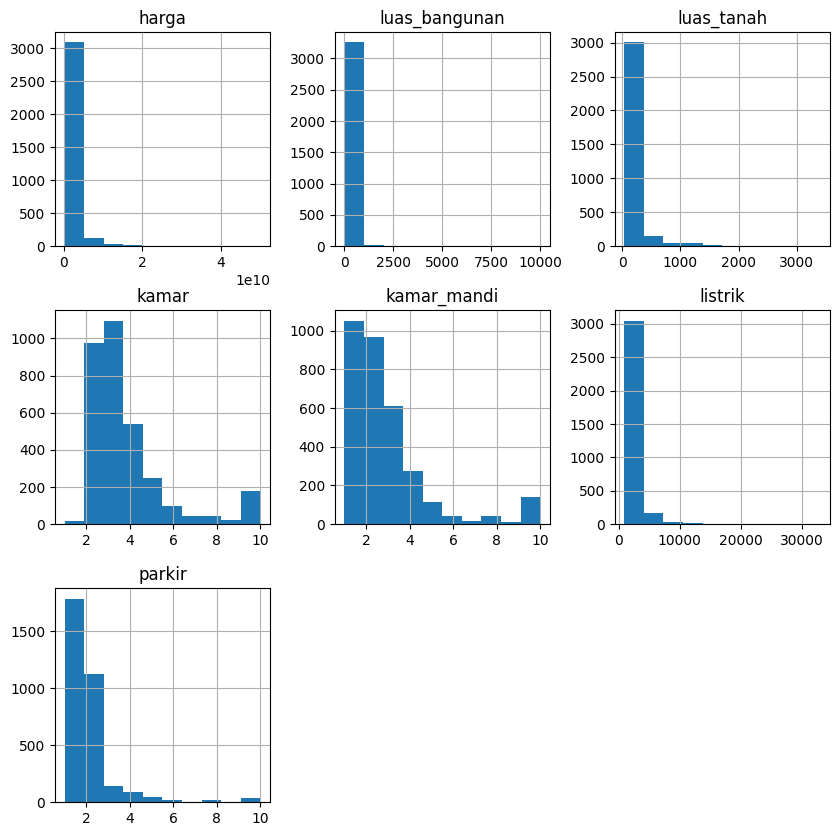

In [26]:
# get bar chart of numbering features
dataset.hist(figsize=(10, 10))

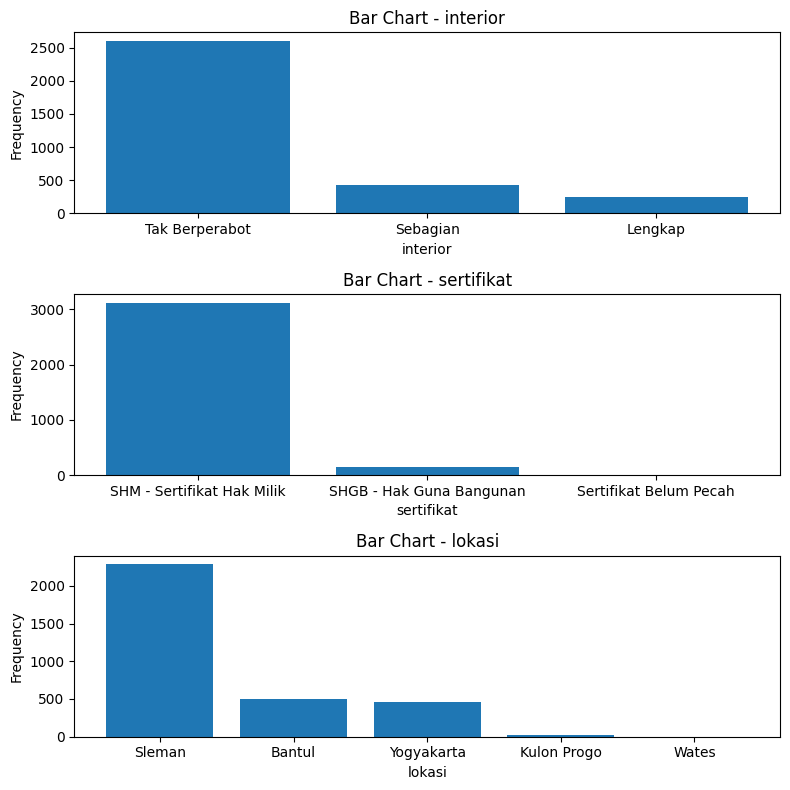

In [40]:
# get bar chart of categorical features
categorical_features = ["interior", "sertifikat", "lokasi"]
num_features = len(categorical_features)

fig, axes = plt.subplots(num_features, 1, figsize=(8, 8))

for i, feature in enumerate(categorical_features):
    feature_frequency = dataset[feature].value_counts()
    axes[i].bar(feature_frequency.index, feature_frequency.values)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title('Bar Chart - {}'.format(feature))

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()



In [15]:
# melihat korelasi antar variabel
numeric_features = dataset.select_dtypes(include=[np.number])
correlation_matrix = numeric_features.corr()
correlation_matrix

,harga,luas_bangunan,luas_tanah,kamar,kamar_mandi,listrik,parkir
harga,1.000000,0.530204,0.690580,0.545877,0.548985,0.588004,0.610713
luas_bangunan,0.530204,1.000000,0.554539,0.501424,0.474520,0.404274,0.421951
luas_tanah,0.690580,0.554539,1.000000,0.495611,0.474501,0.378281,0.616843
kamar,0.545877,0.501424,0.495611,1.000000,0.901506,0.502719,0.551778
kamar_mandi,0.548985,0.474520,0.474501,0.901506,1.000000,0.539576,0.546182
listrik,0.588004,0.404274,0.378281,0.502719,0.539576,1.000000,0.475057
parkir,0.610713,0.421951,0.616843,0.551778,0.546182,0.475057,1.000000


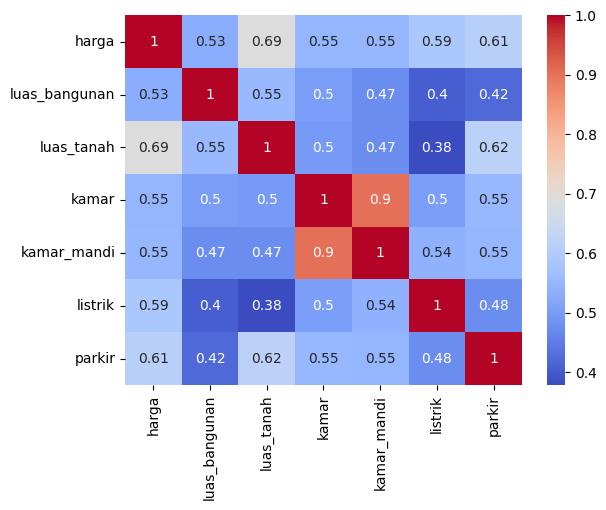

In [17]:
# melihat correlation matrix dalam bentuk grafik heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

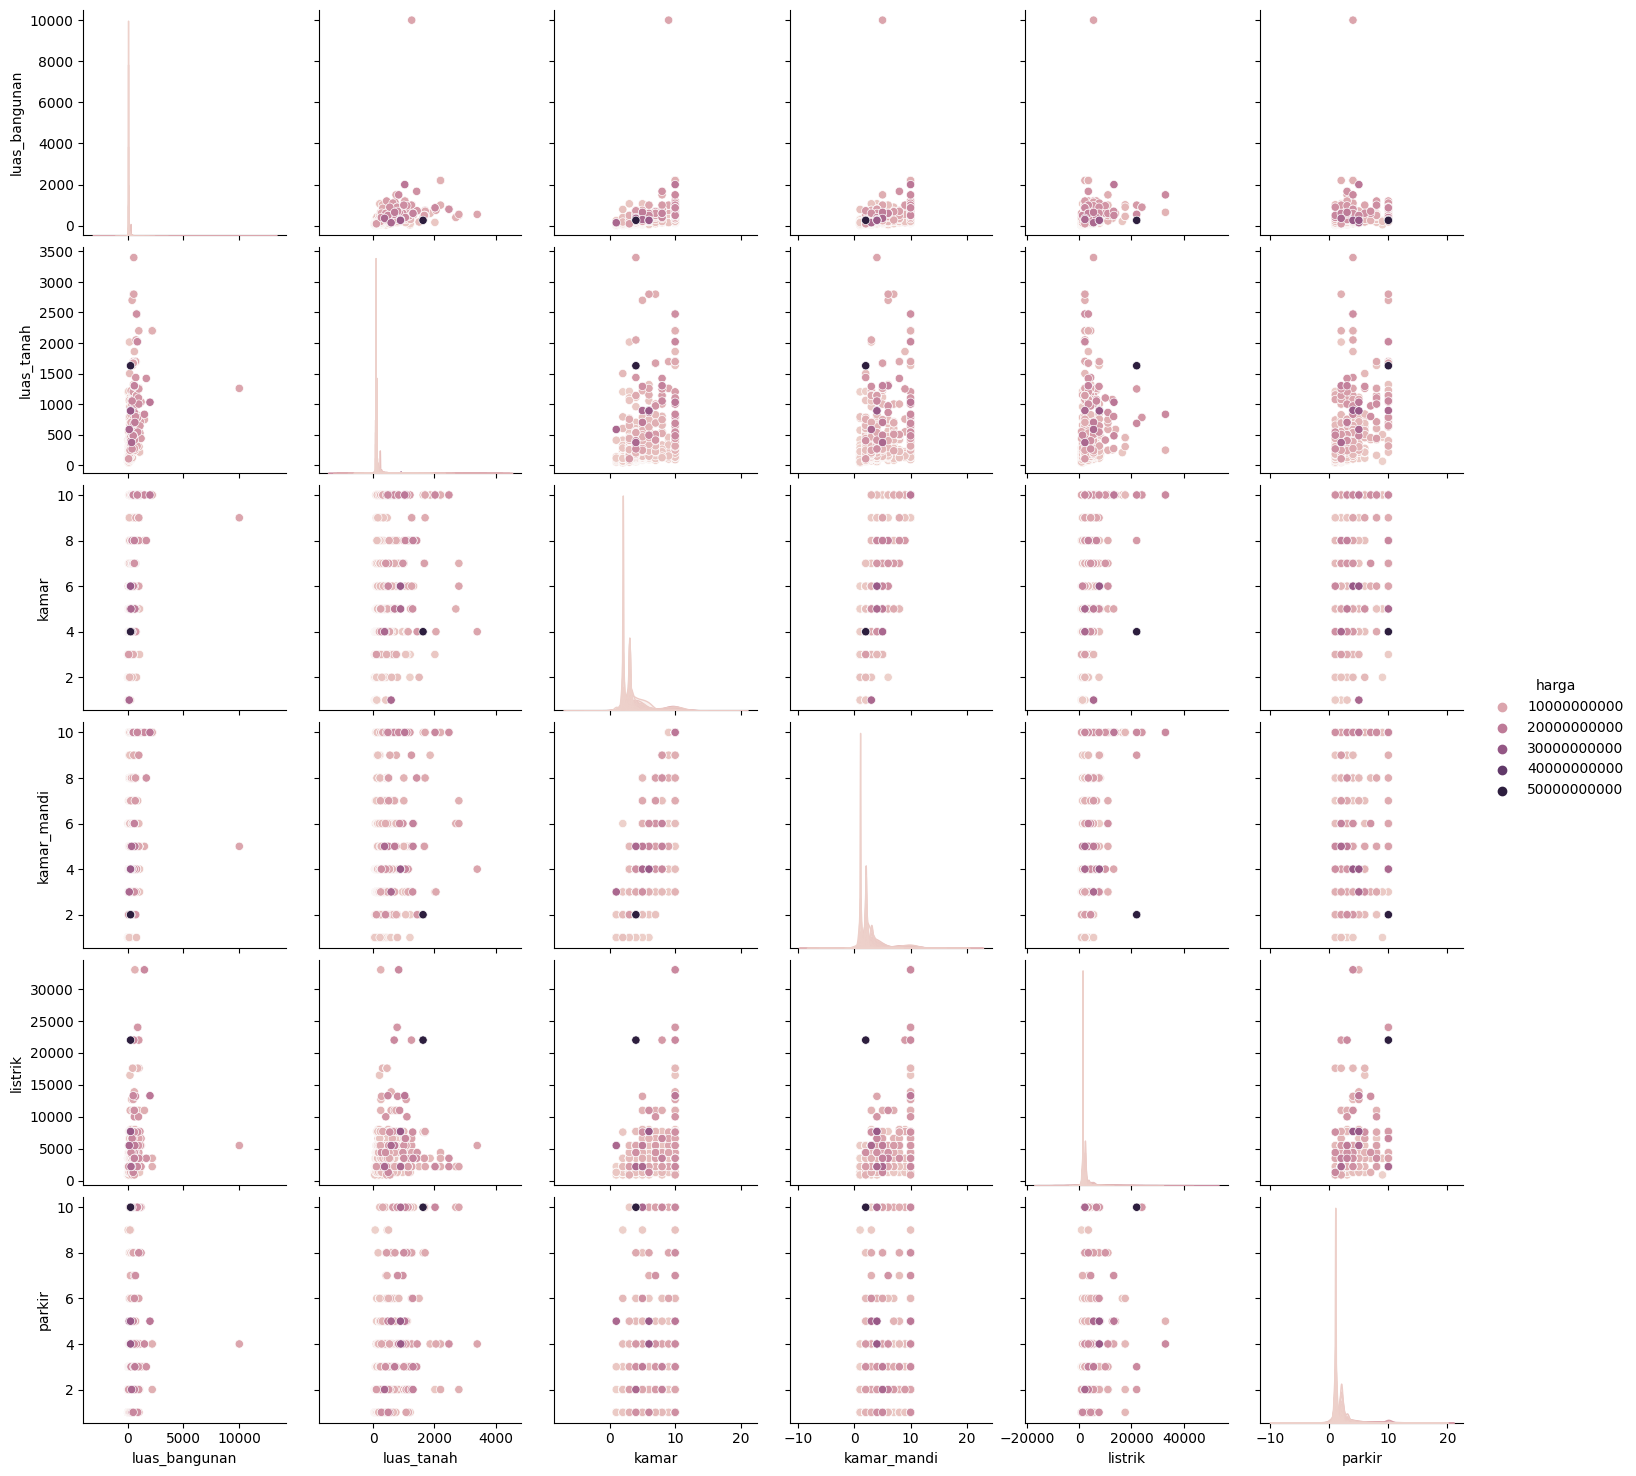

In [42]:
sns.pairplot(dataset, hue="harga")

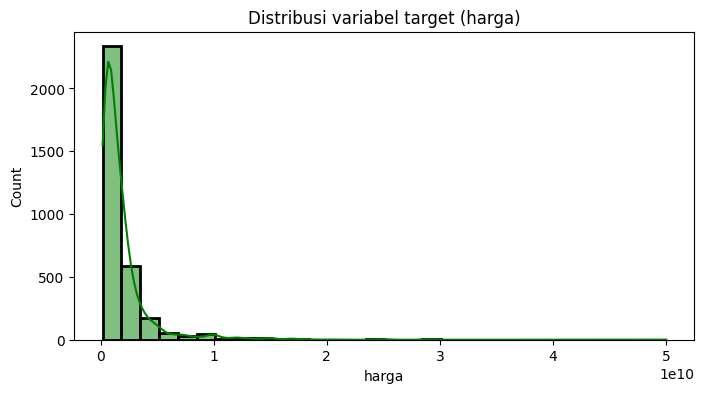

In [11]:
# Melihat distribusi data
plt.figure(figsize=[8, 4])
sns.histplot(data=dataset, x=dataset["harga"], color='g', kde=True, edgecolor="black", linewidth=2, bins=30)
plt.title('Distribusi variabel target (harga)')
plt.show()

### 3. Data preprocessing

In [43]:
# Function to check if a file exists
def file_exists(filename):
    try:
        with open(filename):
            return True
    except FileNotFoundError:
        return False

In [44]:
# Check if the preprocessed data is already available
data_cache_file = "cache/data_cache.joblib"
if file_exists(data_cache_file):
    data, X_encoded, y = joblib.load(data_cache_file)
else:
    # Read the CSV file if data is not cached
    data = pd.read_csv("data/rumahcom_clean.csv")

    # Prepare data
    X = data[["lokasi", "luas_bangunan", "luas_tanah", "kamar", "kamar_mandi", "listrik", "interior", "sertifikat", "parkir"]]
    y = data["harga"]

    # Encode categorical data
    X_encoded = pd.get_dummies(X, columns=["lokasi", "interior", "sertifikat"])

    # Cache the preprocessed data
    joblib.dump((data, X_encoded, y), data_cache_file)

In [45]:
# Split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train.head()


,luas_bangunan,luas_tanah,kamar,kamar_mandi,listrik,parkir,lokasi_Bantul,lokasi_Kulon Progo,lokasi_Sleman,lokasi_Wates,lokasi_Yogyakarta,interior_Lengkap,interior_Sebagian,interior_Tak Berperabot,sertifikat_SHGB - Hak Guna Bangunan,sertifikat_SHM - Sertifikat Hak Milik,sertifikat_Sertifikat Belum Pecah
2601,80,98,3,2,2200,2,False,False,True,False,False,False,False,True,False,True,False
1447,90,111,3,2,1300,1,False,False,False,False,True,False,False,True,False,True,False
2126,90,152,3,2,1300,1,False,False,True,False,False,False,False,True,False,True,False
2321,180,201,4,2,2200,2,True,False,False,False,False,False,True,False,False,True,False
862,53,90,2,1,1300,1,False,False,True,False,False,False,False,True,False,True,False


### 4. Build Random Forest Model

In [46]:
# Check if the trained model is already available
rf_model_cache_file = "cache/rf_model_cache.joblib"
xgb_model_cache_file = "cache/xgb_model_cache.joblib"
if file_exists(rf_model_cache_file):
    best_rf_model = joblib.load(rf_model_cache_file)
else:
    # Perform hyperparameter tuning if the model is not cached
    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [None, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
    }

    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=10)
    grid_search.fit(X_train, y_train)

    best_rf_model = grid_search.best_estimator_
    print("Best parameters:", grid_search.best_params_)

    # Cache the trained model
    joblib.dump(best_rf_model, rf_model_cache_file)

### 4. Build XGB Regressor Model

In [47]:
if file_exists(xgb_model_cache_file):
    best_xgb_model = joblib.load(xgb_model_cache_file)
else:
    # Perform hyperparameter tuning for XGBRegressor if the model is not cached
    param_grid_xgb = {
        "n_estimators": [100, 200],
        "max_depth": [3, 6],
        "learning_rate": [0.1, 0.01],
        "gamma": [0, 0.1],
    }

    grid_search_xgb = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid_xgb, cv=10)
    grid_search_xgb.fit(X_train, y_train)

    best_xgb_model = grid_search_xgb.best_estimator_
    print("Best parameters for XGBRegressor:", grid_search_xgb.best_params_)

    # Cache the trained XGBRegressor model
    joblib.dump(best_xgb_model, xgb_model_cache_file)

### 5. Predict using the combined model

In [48]:
y_train_pred_rf = best_rf_model.predict(X_train)
y_train_pred_xgb = best_xgb_model.predict(X_train)

X_train_combined = pd.DataFrame({
    "RF_Prediction": y_train_pred_rf,
    "XGB_Prediction": y_train_pred_xgb
})

y_test_pred_rf = best_rf_model.predict(X_test)
y_test_pred_xgb = best_xgb_model.predict(X_test)

X_test_combined = pd.DataFrame({
    "RF_Prediction": y_test_pred_rf,
    "XGB_Prediction": y_test_pred_xgb
})

In [49]:
# Train a meta-model (RandomForestRegressor) on the combined predictions
meta_model = RandomForestRegressor(random_state=42)
meta_model.fit(X_train_combined, y_train)


RandomForestRegressor(random_state=42)

### 6. Evaluate the meta-model

In [50]:
train_rmse = mean_squared_error(y_train, meta_model.predict(X_train_combined), squared=False)
train_r2 = r2_score(y_train, meta_model.predict(X_train_combined))
train_mae = mean_absolute_error(y_train, meta_model.predict(X_train_combined))
train_mape = mean_absolute_percentage_error(y_train, meta_model.predict(X_train_combined))
test_rmse = mean_squared_error(y_test, meta_model.predict(X_test_combined), squared=False)
test_r2 = r2_score(y_test, meta_model.predict(X_test_combined))
test_mae = mean_absolute_error(y_test, meta_model.predict(X_test_combined))
test_mape = mean_absolute_percentage_error(y_test, meta_model.predict(X_test_combined))

print("Combined Model:")
print("Training MAPE:", train_mape)
print("Training R2 Score:", train_r2)
print("Training MAE:", train_mae)
print("Training RMSE:", train_rmse, "\n")

print("Testing MAPE:", test_mape)
print("Testing R2 Score:", test_r2)
print("Testing MAE:", test_mae)
print("Testing RMSE:", test_rmse, "\n")


Combined Model:
Training MAPE: 0.03120993113118129
Training R2 Score: 0.9942564557191568
Training MAE: 51796618.927757524
Training RMSE: 202654024.34705448 

Testing MAPE: 0.19748342403060107
Testing R2 Score: 0.6309669612730924
Testing MAE: 397988371.16094434
Testing RMSE: 1401377829.129738 



### 7. Predict with Input Data

In [51]:
# Predict house price
new_data = pd.DataFrame({
    "lokasi_Sleman": [1],
    "lokasi_Yogyakarta": [0],
    "lokasi_Kulon Progo": [0],
    "lokasi_Bantul": [0],
    "lokasi_Wates": [0],
    "luas_bangunan": [90],
    "luas_tanah": [100],
    "kamar": [3],
    "kamar_mandi": [2],
    "listrik": [1300],
    "interior_Tak Berperabot": [1],
    "interior_Lengkap": [0],
    "interior_Sebagian": [0],
    "parkir": [2],
    "sertifikat_SHM - Sertifikat Hak Milik": [1],
    "sertifikat_SHGB - Hak Guna Bangunan": [0],
    "sertifikat_Sertifikat Belum Pecah": [0],
})

# Reorder the columns to match the order used during training
new_data = new_data[X_encoded.columns]

new_data_pred_rf = best_rf_model.predict(new_data)
new_data_pred_xgb = best_xgb_model.predict(new_data)

new_data_combined = pd.DataFrame({
    "RF_Prediction": new_data_pred_rf,
    "XGB_Prediction": new_data_pred_xgb
})

new_data_pred = meta_model.predict(new_data_combined)
print("Predicted house price:", new_data_pred[0])

Predicted house price: 971107378.4704256


In [63]:
importances = best_rf_model.feature_importances_
sorted_indicates = importances.argsort()[::-1]

sorted_indicates

# feature_names = dataset.columns[sorted_indicates]

# # Plot feature importance
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(importances)), importances[sorted_indices])
# plt.xticks(range(len(importances)), feature_names, rotation=90)
# plt.xlabel('Fitur')
# plt.ylabel('Tingkat Kepentingan')
# plt.title('Plot Kepentingan Fitur')
# plt.tight_layout()
# plt.show()


IndexError: index 10 is out of bounds for axis 0 with size 10